First step:
1. Install tenserflow using anaconda
second step :
2. pip install --pre deepchem
then
3. deepchem using anaconda
Third step :
3. Install rdkit unsing anaconda


In [1]:
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from pathlib import Path

In [2]:
tf.__version__

'2.9.1'

In [3]:
pd.__version__

'1.3.5'

In [4]:
Path.cwd()

PosixPath('/Users/adnane/Desktop/Github/QSAR_Adnane_Adib')

In [5]:
%%bash

obabel -i mol2 comp1_multi22-aligned.mol2 -o sdf -O compounds.sdf -p

22 molecules converted


In [6]:
file = "comp1_multi22-activiti"

In [7]:
with open(file, "r") as lines:
    activities = []
    names = []
    next(lines)
    for line in lines:
        acti = line.split("\t")[1]
        activities.append(float(acti))
        name = line.split('"')[1]
        names.append(str(name))

In [8]:
len(activities)

22

In [9]:
Lmol =[]
writer = Chem.SDWriter("compoundsprop.sdf")
for mol, i in zip(Chem.SDMolSupplier("compounds.sdf"), range(len(activities))):
    if mol is not None:
        Lmol.append(mol)
        mol.SetProp("activity", str(activities[i]))
        writer.write(mol)       

In [10]:
df = PandasTools.LoadSDF("compoundsprop.sdf", strictParsing= True)

[23:10:51] ERROR: EOF hit while reading atoms
[23:10:51] ERROR: moving to the beginning of the next molecule


In [11]:
df.shape

(20, 3)

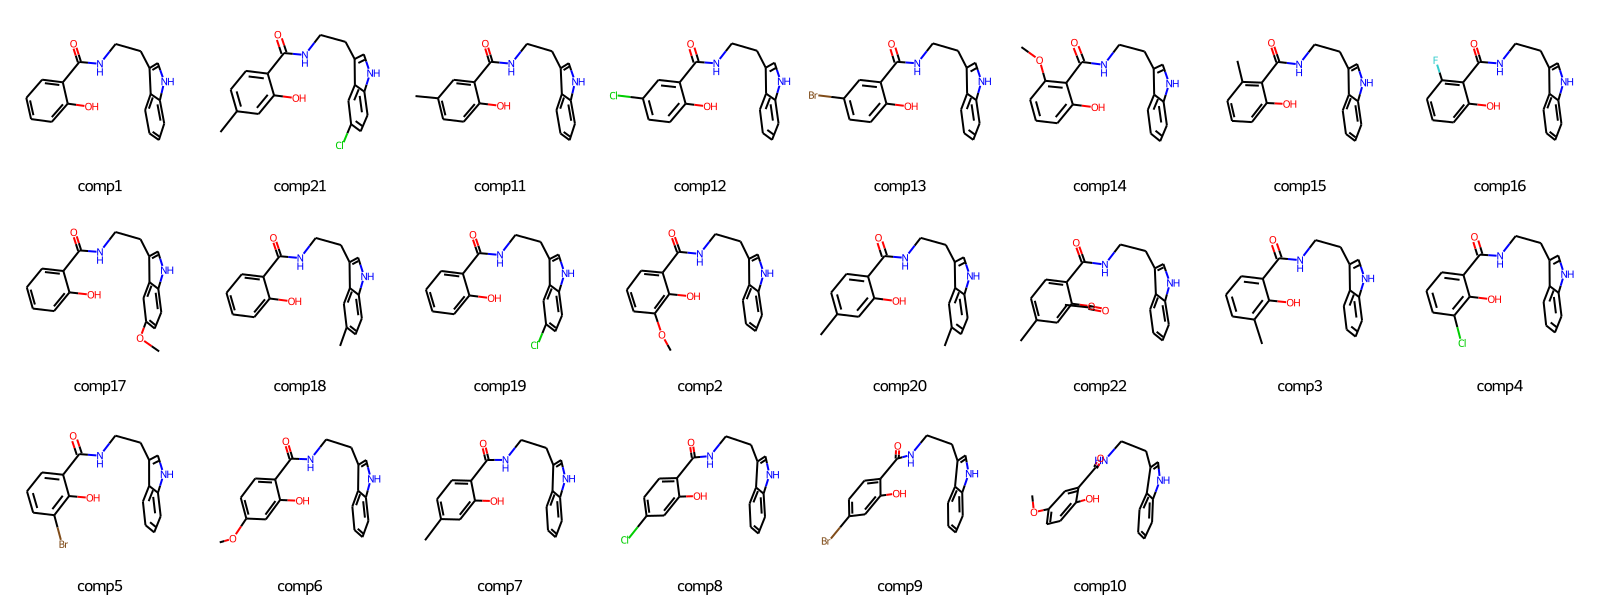

In [12]:
Draw.MolsToGridImage(Lmol, molsPerRow= 8,legends=names)

In [79]:
#PandasTools.WriteSDF(df, "" )

In [13]:
graph_featurizer = dc.feat.graph_features.ConvMolFeaturizer()

In [14]:
graph_featurizer.name

['conv_mol']

In [15]:
import deepchem as dc
import os
#current_dir = os.path.dirname(os.path.realpath(__file__))
#featurizer = dc.feat.CircularFingerprint(size=16)
loader = dc.data.SDFLoader(["activity"], featurizer=graph_featurizer, sanitize=True)
dataset_file = loader.create_dataset("compoundsprop.sdf") # doctest:+ELLIPSIS
len(dataset_file)

[23:11:02] ERROR: EOF hit while reading atoms
[23:11:02] ERROR: moving to the beginning of the next molecule


20

In [16]:
dataset_file

<DiskDataset X.shape: (20,), y.shape: (20, 1), w.shape: (20, 1), ids: ['O=C(NCCc1c[nH]c2ccccc12)c1ccccc1O'
 'Cc1ccc(C(=O)NCCc2c[nH]c3ccc(Cl)cc23)c(O)c1'
 'Cc1ccc(O)c(C(=O)NCCc2c[nH]c3ccccc23)c1' ...
 'COc1ccc(C(=O)NCCc2c[nH]c3ccccc23)c(O)c1'
 'Cc1ccc(C(=O)NCCc2c[nH]c3ccccc23)c(O)c1'
 'O=C(NCCc1c[nH]c2ccccc12)c1ccc(Cl)cc1O'], task_names: ['activity']>

In [41]:
# Splitter splits the dataset 
# In this case it's is an equivalent of train_test_split from sklearn
splitter = dc.splits.RandomSplitter()
# frac_test is 0.01 because we only use a train and valid as an example
train, valid, _ = splitter.train_valid_test_split(dataset_file,
                                                  frac_train=0.7,
                                                  frac_valid=0.29,
                                                  frac_test=0.01)
# Normalizer will normalize y values in the dataset
normalizer = dc.trans.NormalizationTransformer(transform_y=True, 
                                                     dataset=train, 
                                                     move_mean=True)
train = normalizer.transform(train)
test = normalizer.transform(valid)

In [42]:
len(train), len(test)

(14, 5)

In [43]:
from deepchem.models import GraphConvModel

In [48]:
# GraphConvModel is a GNN model based on 
# Duvenaud, David K., et al. "Convolutional networks on graphs for
# learning molecular fingerprints."
graph_conv = dc.models.GraphConvModel(1,
                            batch_size=2,
                            mode="regression")
# Defining metric. Closer to 1 is better
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

In [55]:
# Fitting the model
graph_conv.fit(train, nb_epoch=200)

# Reversing the transformation and getting the metric scores on 2 datasets
train_scores = graph_conv.evaluate(train, [metric], [normalizer])
valid_scores = graph_conv.evaluate(valid, [metric], [normalizer])

In [56]:
train_scores

{'pearson_r2_score': 0.9577177525061645}

In [57]:
valid_scores

{'pearson_r2_score': 0.42920569588637825}

In [33]:
#dataset = loader.featurize(dataset_file)